In [ ]:
from almanac.data import data_module
from almanac.analysis import *
from amanac.strategy import mean_reversion_4

In [ ]:
sp500 = data_module('sp500', freq='1d', start='2013-01-01', end='2023-01-01')

In [ ]:
instruments = get_instruments_given_capital(capital=100000)
trend_forecast = scaled_forecasts(instruments, type="EWMAC", variants=5)
capped_combined_forecasts = cap_forecasts(combine_forecasts(trend_forecasts), ceiling=20)

In [34]:
import pandas as pd

In [35]:
df = pd.read_csv('all_plants_csv_data.csv')

In [36]:
df.loc[df['2021_cost_per_unit'].astype(float).isnull()]

,Unnamed: 0,plant_name,2022_usage,capacity_mw,start,net_generation_gwh,usage,2021_cost_per_unit,2022_cost_per_unit,own_IPP,...,own_RENTAL & SIPP,fuel_GAS,fuel_HFO,fuel_HSD,fuel_HYDRO,fuel_SOLAR,fuel_WIND,location,district_code,2022_units
32,107,Hathazari 100 MW Peaking PP,3.4,98.0,2011.0,-0.8567,0.001,NaN,31.67,False,...,False,False,True,False,False,False,False,"Hathazari, Chattogram",chattogram,25.380539
97,18,Bogura RPP (24MW) 15 yrs,87.0,22.0,2008.0,167.4902,0.870,NaN,4.09,False,...,True,True,False,False,False,False,False,Bogura,bogura,171.722480
125,62,Haripur GTPP,0.0,32.0,NaN,-0.4225,0.000,NaN,693.00,False,...,False,True,False,False,False,False,False,"Haripur, Thakurgaon",thakurgaon,NaN
128,94,Bheramara GT unit-3,0.0,20.0,1980.0,-0.1532,0.000,NaN,NaN,False,...,False,False,False,True,False,False,False,"Bheramara, Kushtia",kushtia,NaN
129,105,Tongi 80 MW GTPP,0.0,105.0,2005.0,-0.2004,0.000,NaN,NaN,False,...,False,True,False,False,False,False,False,"Tongi,Gazipur",gazipur,0.000000
130,110,CLC Power Co. Ltd. 108 MW Bosila Keranigonj,0.0,108.0,2017.0,0.0000,0.000,NaN,NaN,True,...,False,False,True,False,False,False,False,"Washpur, Keraniganj, Dhaka",dhaka,0.000000
131,23,210 MW Shiddirganj TPP,0.0,210.0,2019.0,-1.2870,0.000,NaN,NaN,False,...,False,True,False,False,False,False,False,"Shiddhirganj, Narayanganj",narayanganj,0.000000


In [37]:
# Define the common columns and columns specific to each year
common_columns = ['Unnamed: 0', 'plant_name', 'capacity_mw', 'start', 'own_IPP', 'own_Joint venture', 'own_Public', 'own_RENTAL & SIPP',
                  'fuel_GAS', 'fuel_HFO', 'fuel_HSD', 'fuel_HYDRO', 'fuel_SOLAR', 'fuel_WIND', 'district_code']

columns_2021 = ['net_generation_gwh', 'usage', '2021_cost_per_unit']
columns_2022 = ['2022_cost_per_unit', '2022_usage', '2022_units']

# Create DataFrames for 2021 and 2022
df_2021 = df[common_columns + columns_2021].copy()
df_2022 = df[common_columns + columns_2022].copy()

# Add a 'year' column to each DataFrame
df_2021['year'] = 2021
df_2022['year'] = 2022

# Rename the year-specific columns to be consistent across both DataFrames
rename_dict_2021 = {col: col.replace('2021_', '') for col in columns_2021}
rename_dict_2022 = {col: col.replace('2022_', '') for col in columns_2022}

df_2021.rename(columns=rename_dict_2021, inplace=True)
df_2022.rename(columns=rename_dict_2022, inplace=True)

# # Concatenate the two DataFrames to create the panel dataset
# panel_df = pd.concat([df_2021, df_2022], ignore_index=True)

# # Show first few rows of the panel dataset
# panel_df.head()

# Correct the column name mappings between 2021 and 2022
correct_mapping = {'net_generation_gwh': 'units', 'usage': 'usage', '2021_cost_per_unit': 'cost_per_unit'}

# Rename the columns for 2021 and 2022 DataFrames based on the correct mapping
df_2021.rename(columns=correct_mapping, inplace=True)
df_2022.rename(columns=correct_mapping, inplace=True)

In [38]:
df.columns

Index(['Unnamed: 0', 'plant_name', '2022_usage', 'capacity_mw', 'start',
       'net_generation_gwh', 'usage', '2021_cost_per_unit',
       '2022_cost_per_unit', 'own_IPP', 'own_Joint venture', 'own_Public',
       'own_RENTAL & SIPP', 'fuel_GAS', 'fuel_HFO', 'fuel_HSD', 'fuel_HYDRO',
       'fuel_SOLAR', 'fuel_WIND', 'location', 'district_code', '2022_units'],
      dtype='object')

In [39]:
# What are these ultra-expensive plants?
df['low_cap_usage'] = 1/(df['usage']*df['net_generation_gwh'])

In [48]:
df['avg_cost'] = df[['2021_cost_per_unit','2022_cost_per_unit']].mean(axis=1)

In [51]:
df.describe()

/home/qavi/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


,Unnamed: 0,2022_usage,capacity_mw,start,net_generation_gwh,usage,2021_cost_per_unit,2022_cost_per_unit,2022_units,low_cap_usage,avg_cost
count,132.000000,131.000000,132.000000,128.000000,132.000000,131.000000,125.00000,123.000000,126.000000,131.000000,128.000000
mean,47.348485,38.543435,134.256818,2011.312500,439.182322,0.354229,16.92272,26.341834,514.712516,NaN,23.894084
std,31.990692,27.616864,117.358845,10.944923,573.593913,0.255948,32.50986,87.708256,641.503174,NaN,70.429467
min,0.000000,0.000000,0.000000,1962.000000,-2.206000,0.000000,1.68000,1.330000,0.000000,-inf,1.685000
25%,18.000000,12.950000,52.000000,2009.000000,54.997975,0.140000,3.45000,3.825000,80.368673,0.002884,3.676250
50%,46.500000,39.300000,104.000000,2015.000000,219.201650,0.340000,9.93000,15.090000,239.754249,0.008986,12.077500
75%,71.250000,62.500000,200.000000,2019.000000,536.242850,0.543000,12.70000,17.435000,638.558896,0.063919,15.585000
max,110.000000,87.000000,622.000000,2022.000000,2945.236600,0.890000,218.79000,693.000000,2841.908964,inf,693.000000


In [50]:
df.sort_values(by=['avg_cost'], ascending=False).dropna().head(20)[['plant_name', '2021_cost_per_unit', '2022_cost_per_unit', 'capacity_mw', 'start', 'own_IPP', 'own_Public',
       'own_RENTAL & SIPP', 'fuel_GAS', 'fuel_HFO', 'fuel_HSD', 'location']]

,plant_name,2021_cost_per_unit,2022_cost_per_unit,capacity_mw,start,own_IPP,own_Public,own_RENTAL & SIPP,fuel_GAS,fuel_HFO,fuel_HSD,location
7,Ghorasal Repowered CCPP Unit-3,3.13,681.000000,260.0,2021.0,False,True,False,True,False,False,"Palash, Narsingdi"
21,Saidpur 20 MW /GT,95.47,182.970000,20.0,1987.0,False,True,False,False,False,True,"Saidpur, Nilphamari"
25,Gopalganj 100 MW Peaking PP,218.79,51.490000,109.0,2011.0,False,True,False,False,True,False,Gopalganj
23,Rangpur 20 MW /GT,150.66,113.920000,20.0,1988.0,False,True,False,False,False,True,"Darshana, Rangpur Sadar, Rangpur"
24,Paramount Baghabari BanglaTrack,180.67,55.390000,200.0,2019.0,True,False,False,False,False,True,"Baghbari, Sylhet"
33,Modhumoti 105 MW NWPGCL,127.97,28.450000,105.0,2019.0,False,True,False,False,True,False,"Modhumoti, Bagerhat"
26,Daudkandi 200MW(Bangla Trac),105.72,42.330000,200.0,2018.0,True,False,False,False,False,True,"Gouripur, Titas Upazila, Cumilla"
29,"Aggreko, Brahmangaon 100MW",76.01,35.240000,100.0,2019.0,True,False,False,False,False,True,"Brahmangaon, Keraniganj"
30,"Aggreko, Aourahati 100MW",64.13,33.580000,100.0,2020.0,True,False,False,False,False,True,"Aowrahati, Keraniganj, Dhaka"
37,Faridpur 50 MW Peaking PP,46.96,20.930000,54.0,2011.0,False,True,False,False,True,False,"Dhuldi, Faridpur Sadar Upazila, Faridpur"


In [43]:
df.sort_values(by=['low_cap_usage'], ascending=False).head(20)[['plant_name', '2021_cost_per_unit', 'capacity_mw', 'start', 'own_IPP', 'own_Public',
       'own_RENTAL & SIPP', 'fuel_GAS', 'fuel_HFO', 'fuel_HSD', 'location']]

,plant_name,2021_cost_per_unit,capacity_mw,start,own_IPP,own_Public,own_RENTAL & SIPP,fuel_GAS,fuel_HFO,fuel_HSD,location
130,CLC Power Co. Ltd. 108 MW Bosila Keranigonj,NaN,108.0,2017.0,True,False,False,False,True,False,"Washpur, Keraniganj, Dhaka"
17,Rauzan 210 MW /ST (2nd),5.20,210.0,1997.0,False,True,False,True,False,False,"Raozan, Chattogram"
23,Rangpur 20 MW /GT,150.66,20.0,1988.0,False,True,False,False,False,True,"Darshana, Rangpur Sadar, Rangpur"
21,Saidpur 20 MW /GT,95.47,20.0,1987.0,False,True,False,False,False,True,"Saidpur, Nilphamari"
25,Gopalganj 100 MW Peaking PP,218.79,109.0,2011.0,False,True,False,False,True,False,Gopalganj
33,Modhumoti 105 MW NWPGCL,127.97,105.0,2019.0,False,True,False,False,True,False,"Modhumoti, Bagerhat"
24,Paramount Baghabari BanglaTrack,180.67,200.0,2019.0,True,False,False,False,False,True,"Baghbari, Sylhet"
37,Faridpur 50 MW Peaking PP,46.96,54.0,2011.0,False,True,False,False,True,False,"Dhuldi, Faridpur Sadar Upazila, Faridpur"
63,Sharishabari 3 MW Engreen Solar Power Plant,16.11,3.0,2017.0,True,False,False,False,False,False,"Sarishabari, Jamalpur"
26,Daudkandi 200MW(Bangla Trac),105.72,200.0,2018.0,True,False,False,False,False,True,"Gouripur, Titas Upazila, Cumilla"


In [17]:
panel_df = pd.concat([df_2021, df_2022], ignore_index=True)

In [18]:
panel_df.replace('-', pd.NA, inplace=True)

In [19]:
panel_df.drop(columns=['Unnamed: 0']).isnull().sum()

plant_name            0
capacity_mw           0
start                 8
own_IPP               0
own_Joint venture     0
own_Public            0
own_RENTAL & SIPP     0
fuel_GAS              0
fuel_HFO              0
fuel_HSD              0
fuel_HYDRO            0
fuel_SOLAR            0
fuel_WIND             0
district_code         2
units                 6
usage                 2
cost_per_unit        16
year                  0
dtype: int64

In [20]:
panel_df['usage'] = panel_df.usage.fillna(0)

In [21]:
panel_df.drop(columns=['Unnamed: 0'], inplace=True)

In [22]:
## 2022 USAGE IS UNUSABLE!! (First 18 values sorted by descending need to be checked)
df.replace('-', pd.NA, inplace=True)
df['2022_cost_per_unit'] = pd.to_numeric(df['2022_cost_per_unit'], errors='coerce')
df.sort_values(by=['2022_cost_per_unit'], ascending=False).head(2)

,Unnamed: 0,plant_name,2022_usage,capacity_mw,start,net_generation_gwh,usage,2021_cost_per_unit,2022_cost_per_unit,own_IPP,...,own_RENTAL & SIPP,fuel_GAS,fuel_HFO,fuel_HSD,fuel_HYDRO,fuel_SOLAR,fuel_WIND,location,district_code,2022_units
125,62,Haripur GTPP,0.0,32.0,NaN,-0.4225,0.000,NaN,693.0,False,...,False,True,False,False,False,False,False,"Haripur, Thakurgaon",thakurgaon,NaN
7,95,Ghorasal Repowered CCPP Unit-3,0.3,260.0,2021.0,47.1487,0.023,3.13,681.0,False,...,False,True,False,False,False,False,False,"Palash, Narsingdi",narsingdi,2.669579


In [24]:
panel_df.loc[panel_df["year"]==2021].isnull().sum()

plant_name           0
capacity_mw          0
start                4
own_IPP              0
own_Joint venture    0
own_Public           0
own_RENTAL & SIPP    0
fuel_GAS             0
fuel_HFO             0
fuel_HSD             0
fuel_HYDRO           0
fuel_SOLAR           0
fuel_WIND            0
district_code        1
units                0
usage                0
cost_per_unit        7
year                 0
dtype: int64

In [25]:
panel_df['district_code']
#= panel_df['district_code'].astype('category').cat.codes

0         habiganj
1         habiganj
2       chattogram
3          jessore
4        narsingdi
          ...     
259          bogra
260        kushtia
261        gazipur
262          dhaka
263    narayanganj
Name: district_code, Length: 264, dtype: object

In [26]:

rename_hyphens = {'own_Joint venture' : 'own_Joint_venture', 'own_RENTAL & SIPP':'own_RENTAL_SIPP'}
panel_df.rename(columns=rename_hyphens, inplace=True)

In [27]:
panel_df['fuel_Coal'] = panel_df[['fuel_GAS', 'fuel_HFO', 'fuel_HSD', 'fuel_HYDRO',
       'fuel_SOLAR', 'fuel_WIND']].sum(axis=1)==0

In [33]:
panel_df.loc[panel_df["year"]==2021]

,plant_name,capacity_mw,start,own_IPP,own_Joint_venture,own_Public,own_RENTAL_SIPP,fuel_GAS,fuel_HFO,fuel_HSD,fuel_HYDRO,fuel_SOLAR,fuel_WIND,district_code,units,usage,cost_per_unit,year,fuel_Coal
0,Bibiyana - South 383 MW CCPP,383.0,2021.0,False,False,True,False,True,False,False,False,False,False,habiganj,1351.3021,0.406,1.95,2021,False
1,Shahjibazar 330 MW CCPP,330.0,2016.0,False,False,True,False,True,False,False,False,False,False,habiganj,1505.2982,0.546,2.84,2021,False
2,"Sangu, Dohazari-kaliaish 100 MW PPP",102.0,2011.0,False,False,True,False,False,True,False,False,False,False,chattogram,203.2578,0.234,13.40,2021,False
3,Khanjahan Ali Noapara 40 MW,40.0,2011.0,False,False,False,True,False,True,False,False,False,False,jessore,92.2828,0.290,14.77,2021,False
4,Ghorashal 78 MW QRPP (3 Yrs Max Power),78.0,2011.0,False,False,False,True,True,False,False,False,False,False,narsingdi,102.4493,0.350,7.92,2021,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,Bogura 20 RPP (3 Yrs) Energy Prima,20.0,2011.0,False,False,False,True,True,False,False,False,False,False,bogra,30.3411,0.170,3.47,2021,False
128,Bheramara GT unit-3,20.0,1980.0,False,False,True,False,False,False,True,False,False,False,kushtia,-0.1532,0.000,NaN,2021,False
129,Tongi 80 MW GTPP,105.0,2005.0,False,False,True,False,True,False,False,False,False,False,gazipur,-0.2004,0.000,NaN,2021,False
130,CLC Power Co. Ltd. 108 MW Bosila Keranigonj,108.0,2017.0,True,False,False,False,False,True,False,False,False,False,dhaka,0.0000,0.000,NaN,2021,False


<Axes: >

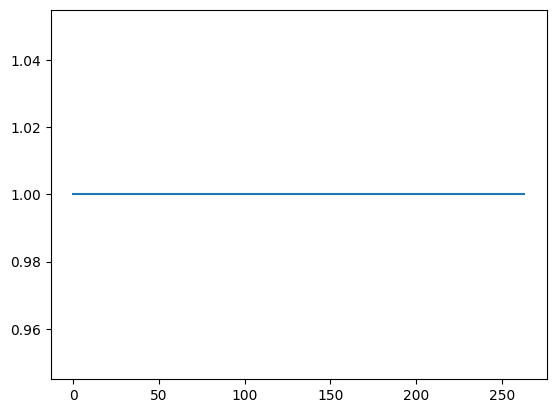

In [28]:
panel_df[['own_IPP', 'own_Joint_venture', 'own_Public',
       'own_RENTAL_SIPP']].sum(axis=1).plot()

In [29]:
panel_df.to_csv('panel_df.csv')
panel_df = pd.read_csv('panel_df.csv', index_col=0)

In [30]:
# Define a dictionary for variable labels
variable_labels = {
    "capacity_mw": "Plant capacity in Megawatts",
    "start": "Start year of operation",
    "own_IPP": "Ownership by Independent Power Producer (1 if yes, 0 if no)",
    "own_Joint venture": "Ownership by Joint Venture (1 if yes, 0 if no)",
    "own_Public": "Public Ownership (1 if yes, 0 if no)",
    "own_RENTAL & SIPP": "Ownership by Rental & SIPP (1 if yes, 0 if no)",
    "fuel_GAS": "Uses Gas as Fuel (1 if yes, 0 if no)",
    "fuel_HFO": "Uses Heavy Fuel Oil as Fuel (1 if yes, 0 if no)",
    "fuel_HSD": "Uses High-Speed Diesel as Fuel (1 if yes, 0 if no)",
    "fuel_HYDRO": "Uses Hydro as Fuel (1 if yes, 0 if no)",
    "fuel_SOLAR": "Uses Solar as Fuel (1 if yes, 0 if no)",
    "fuel_WIND": "Uses Wind as Fuel (1 if yes, 0 if no)",
    "units": "Units generated in GWh for 2022",
    "usage": "Power usage for 2022",
    "cost_per_unit": "Cost per unit of energy produced in 2022",
    "year": "Year of the record",
    "plant_name": "Name of the power plant",
    # Adding any additional columns that may not have labels
}

# File path to save the Stata .dta file
dta_file_path = 'panel_df.dta'

# Save the DataFrame to a Stata .dta file with variable labels
panel_df.to_stata(dta_file_path, variable_labels=variable_labels, write_index=False)


In [ ]:
# Next

In [5]:
alld = pd.read_excel('all_plants_true_data.xlsx', index_col=None, header=0, sheet_name='2022_usage_added')  

In [6]:
alld.columns

Index(['Unnamed: 0', 'plant_name', 'plant_name_x', '2022_usage', 'capacity_mw',
       'start', 'net_generation_gwh', 'usage', '2021_cost_per_unit',
       '2022_cost_per_unit', 'own_IPP', 'own_Joint venture', 'own_Public',
       'own_RENTAL & SIPP', 'fuel_GAS', 'fuel_HFO', 'fuel_HSD', 'fuel_HYDRO',
       'fuel_SOLAR', 'fuel_WIND'],
      dtype='object')

In [8]:
alld.isna().sum()

Unnamed: 0            0
plant_name            0
plant_name_x          0
2022_usage            6
capacity_mw           0
start                 4
net_generation_gwh    0
usage                 6
2021_cost_per_unit    7
2022_cost_per_unit    6
own_IPP               0
own_Joint venture     0
own_Public            0
own_RENTAL & SIPP     0
fuel_GAS              0
fuel_HFO              0
fuel_HSD              0
fuel_HYDRO            0
fuel_SOLAR            0
fuel_WIND             0
dtype: int64

In [9]:
alld.describe()

,Unnamed: 0,2022_usage,capacity_mw,start,net_generation_gwh,usage,2021_cost_per_unit
count,132.000000,126.000000,132.000000,128.000000,132.000000,126.000000,125.00000
mean,47.348485,39.283254,134.250000,2011.312500,439.182322,0.368286,16.92272
std,31.990692,27.474290,117.366678,10.944923,573.593913,0.250821,32.50986
min,0.000000,0.000000,0.000000,1962.000000,-2.206000,0.000000,1.68000
25%,18.000000,13.100000,52.000000,2009.000000,54.997975,0.152250,3.45000
50%,46.500000,40.150000,104.000000,2015.000000,219.201650,0.350000,9.93000
75%,71.250000,62.750000,200.000000,2019.000000,536.242850,0.547500,12.70000
max,110.000000,87.000000,622.000000,2022.000000,2945.236600,0.890000,218.79000


In [10]:
alld.loc[alld.start.isna()]

,Unnamed: 0,plant_name,plant_name_x,2022_usage,capacity_mw,start,net_generation_gwh,usage,2021_cost_per_unit,2022_cost_per_unit,own_IPP,own_Joint venture,own_Public,own_RENTAL & SIPP,fuel_GAS,fuel_HFO,fuel_HSD,fuel_HYDRO,fuel_SOLAR,fuel_WIND
33,62,Haripur GTPP,Haripur GTPP,NaN,32,NaN,-0.4225,NaN,NaN,-693.232517,False,False,True,False,True,False,False,False,False,False
52,23,Dhaka(Doreen) Southern Power Ltd.Nobabgonj,Dhaka(Doreen) Southern Power Ltd.Nobabgonj,64.0,55,NaN,237.8964,0.490,11.28,16.2,True,False,False,False,False,True,False,False,False,False
56,1,Powerpac Mutiara Jamalpur Power plant Ltd,Powerpac Mutiara Jamalpur Power plant Ltd,2.0,95,NaN,289.7374,0.350,11.28,22.02,True,False,False,False,False,True,False,False,False,False
107,18,Sirajgonj 210 MW CC (NWPGCL) Unit-3,Sirajgonj 210 MW CC (NWPGCL) Unit-3,66.0,220,NaN,1447.0055,0.781,3.38,3.89,False,False,True,False,True,False,False,False,False,False


In [11]:
alld.columns

Index(['Unnamed: 0', 'plant_name', 'plant_name_x', '2022_usage', 'capacity_mw',
       'start', 'net_generation_gwh', 'usage', '2021_cost_per_unit',
       '2022_cost_per_unit', 'own_IPP', 'own_Joint venture', 'own_Public',
       'own_RENTAL & SIPP', 'fuel_GAS', 'fuel_HFO', 'fuel_HSD', 'fuel_HYDRO',
       'fuel_SOLAR', 'fuel_WIND'],
      dtype='object')

In [ ]:
21 columns = ['net_generation_gwh', 'usage', '2021_cost_per_unit',]
22_columns = ['2022_cost_per_unit', '2022_usage']

In [15]:
xd = alld.drop(columns=['Unnamed: 0', 'plant_name_x'])

In [13]:
def get_plf_estimates(df, capacity_col, net_generation_col):
    # Create new plf variable
    final_df = df.copy()
    final_df["plf"] = ((final_df[net_generation_col])*0.001)/(final_df[capacity_col]+1)
    sgate = final_df[["usage", "plf"]].plf
    final_df["plf"] = (sgate - sgate.min())/sgate.max()
    print('Correlation estimates')
    print(final_df[["usage", "plf"]].corr())
    
    # Regress plf on usage
    import statsmodels.api as sm
    xd = final_df[["usage", "plf"]]
    raw_df = xd.apply(lambda x : pd.to_numeric(x, errors="coerce")).dropna().astype('float64')
    X = sm.add_constant(raw_df[["plf"]]) # Adding a constant (intercept) term
    model = sm.OLS(raw_df.usage, X).fit()
    summary = model.summary()
    print(summary)
    
    #predicted_vals = constant_term + plf_coeff*final_df["plf"]
    return model.params

def plf_creation(df, capacity_col, net_generation_col, constant_term, plf_coeff):
    final_df = df.copy()
    final_df["plf"] = ((final_df[net_generation_col])*0.001)/(final_df[capacity_col]+1)
    sgate = final_df[["usage", "plf"]].plf
    final_df["plf"] = (sgate - sgate.min())/sgate.max()
    predicted_vals = constant_term + plf_coeff*final_df["plf"]
    return predicted_vals

In [31]:
def get_units_estimates(df, capacity_col, usage_col):
    # Create new plf variable
    final_df = df.copy()
    final_df["units"] = (final_df[capacity_col]+1)*(final_df[usage_col])/0.001
    sgate = final_df[["net_generation_gwh", "units"]].units
    final_df["units"] = (sgate - sgate.min())/sgate.max()
    print('Correlation estimates')
    print(final_df[["net_generation_gwh", "units"]].corr())
    
    # Regress plf on usage
    import statsmodels.api as sm
    xd = final_df[["net_generation_gwh", "units"]]
    raw_df = xd.apply(lambda x : pd.to_numeric(x, errors="coerce")).dropna().astype('float64')
    X = sm.add_constant(raw_df[["units"]]) # Adding a constant (intercept) term
    model = sm.OLS(raw_df.net_generation_gwh, X).fit()
    summary = model.summary()
    print(summary)
    
    #predicted_vals = constant_term + plf_coeff*final_df["plf"]
    return model.params

def plf_creation(df, capacity_col, usage_col, constant_term, plf_coeff):
    final_df = df.copy()
    final_df["units"] = (final_df[capacity_col]+1)*(final_df[usage_col])/0.001
    sgate = final_df[["net_generation_gwh", "units"]].units
    final_df["units"] = (sgate - sgate.min())/sgate.max()
    predicted_vals = constant_term + plf_coeff*final_df["units"]
    return predicted_vals

In [32]:
constant_term, plf_coeff = get_units_estimates(xd, 'capacity_mw', 'usage')

Correlation estimates
                    net_generation_gwh     units
net_generation_gwh            1.000000  0.996554
units                         0.996554  1.000000
                            OLS Regression Results                            
Dep. Variable:     net_generation_gwh   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                 1.790e+04
Date:                Mon, 16 Oct 2023   Prob (F-statistic):          6.14e-136
Time:                        20:20:39   Log-Likelihood:                -666.10
No. Observations:                 126   AIC:                             1336.
Df Residuals:                     124   BIC:                             1342.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err         

In [34]:
capacity_col = "capacity_mw"
usage_col = "2022_usage"
plf_creation(xd, capacity_col, usage_col, constant_term, plf_coeff)

0        78.961877
1        -4.214929
2       149.477520
3       159.588865
4       165.655673
          ...     
127    2091.040461
128    2841.908964
129    2214.258195
130    2093.748544
131     659.616872
Name: units, Length: 132, dtype: float64

In [36]:
xd['2022_units'] = plf_creation(xd, capacity_col, usage_col, constant_term, plf_coeff)
xd[["net_generation_gwh", "2022_units"]].corr()

,net_generation_gwh,2022_units
net_generation_gwh,1.000000,0.919445
2022_units,0.919445,1.000000


<Axes: >

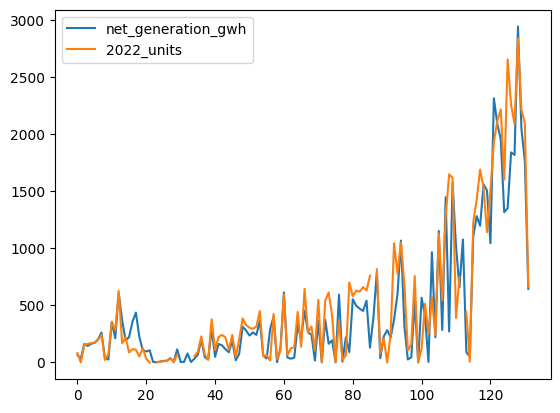

In [37]:
xd[["net_generation_gwh", "2022_units"]].plot()

In [38]:
xd[["net_generation_gwh", "2022_units"]]

,net_generation_gwh,2022_units
0,61.4628,78.961877
1,30.3411,-4.214929
2,157.7652,149.477520
3,141.1988,159.588865
4,160.0048,165.655673
...,...,...
127,1817.5804,2091.040461
128,2945.2366,2841.908964
129,2049.4159,2214.258195
130,1762.5061,2093.748544


In [43]:
xd.loc[xd['2022_units']<0].index

Index([1, 21, 23, 28, 31, 71, 75, 90, 99], dtype='int64')

In [47]:
xd.loc[xd.loc[xd['2022_units']<0].index]['2022_units'] = 0

In [49]:
for i in xd.index:
    if i in xd.loc[xd['2022_units']<0].index:
        xd.at[i, '2022_units'] = 0

In [52]:
xd.columns

Index(['plant_name', '2022_usage', 'capacity_mw', 'start',
       'net_generation_gwh', 'usage', '2021_cost_per_unit',
       '2022_cost_per_unit', 'own_IPP', 'own_Joint venture', 'own_Public',
       'own_RENTAL & SIPP', 'fuel_GAS', 'fuel_HFO', 'fuel_HSD', 'fuel_HYDRO',
       'fuel_SOLAR', 'fuel_WIND', '2022_units'],
      dtype='object')

In [53]:
xd.to_csv('allcols_22.csv')

In [54]:
# Panelized

In [72]:
adf = pd.read_csv('panel_data_corrected.csv', index_col=0)

In [73]:
adf.columns

Index(['plant_name', 'capacity_mw', 'start', 'own_IPP', 'own_Joint venture',
       'own_Public', 'own_RENTAL & SIPP', 'fuel_GAS', 'fuel_HFO', 'fuel_HSD',
       'fuel_HYDRO', 'fuel_SOLAR', 'fuel_WIND', 'units', 'usage',
       'cost_per_unit', 'year'],
      dtype='object')

In [74]:
adf['cost_per_unit'] = pd.to_numeric(adf['cost_per_unit'].str.replace(',', '.'), errors='coerce')

In [75]:
adf = adf.drop(columns=['plant_name']).astype('float')

In [76]:
adf['plant_name'] = pd.read_csv('panel_data_corrected.csv', index_col=0)['plant_name']

In [77]:
plant_name_to_id = {name: idx for idx, name in enumerate(adf['plant_name'].unique())}
adf['id'] = adf['plant_name'].map(plant_name_to_id)

In [78]:
len(adf.id.unique())

132

In [79]:
adf.columns

Index(['capacity_mw', 'start', 'own_IPP', 'own_Joint venture', 'own_Public',
       'own_RENTAL & SIPP', 'fuel_GAS', 'fuel_HFO', 'fuel_HSD', 'fuel_HYDRO',
       'fuel_SOLAR', 'fuel_WIND', 'units', 'usage', 'cost_per_unit', 'year',
       'plant_name', 'id'],
      dtype='object')

In [80]:
adf.to_csv('bd_power_plants.csv')

In [81]:
stata_file_path = 'bd_power_plants.dta'
adf.to_stata(stata_file_path, write_index=False)

/tmp/ipykernel_15505/1645493957.py:2: InvalidColumnName: 
Not all pandas column names were valid Stata variable names.
The following replacements have been made:

    own_Joint venture   ->   own_Joint_venture
    own_RENTAL & SIPP   ->   own_RENTAL___SIPP

If this is not what you expect, please make sure you have Stata-compliant
column names in your DataFrame (strings only, max 32 characters, only
alphanumerics and underscores, no Stata reserved words)

  adf.to_stata(stata_file_path, write_index=False)


In [82]:
adf.isna().sum()

capacity_mw           0
start                 8
own_IPP               0
own_Joint venture     0
own_Public            0
own_RENTAL & SIPP     0
fuel_GAS              0
fuel_HFO              0
fuel_HSD              0
fuel_HYDRO            0
fuel_SOLAR            0
fuel_WIND             0
units                 6
usage                12
cost_per_unit        17
year                  0
plant_name            0
id                    0
dtype: int64

In [86]:
adf.rename(columns={'own_RENTAL & SIPP':'own_RENTAL_SIPP'}, inplace=True)

In [87]:
# Define the variable labels based on inference
var_labels = {
    'capacity_mw': 'Plant capacity in Megawatts',
    'start': 'Start year of operation',
    'own_IPP': 'Ownership by Independent Power Producer (1 if yes, 0 if no)',
    'own_Joint venture': 'Ownership by Joint Venture (1 if yes, 0 if no)',
    'own_Public': 'Public Ownership (1 if yes, 0 if no)',
    'own_RENTAL & SIPP': 'Ownership by Rental & SIPP (1 if yes, 0 if no)',
    'fuel_GAS': 'Uses Gas as Fuel (1 if yes, 0 if no)',
    'fuel_HFO': 'Uses Heavy Fuel Oil as Fuel (1 if yes, 0 if no)',
    'fuel_HSD': 'Uses High-Speed Diesel as Fuel (1 if yes, 0 if no)',
    'fuel_HYDRO': 'Uses Hydro as Fuel (1 if yes, 0 if no)',
    'fuel_SOLAR': 'Uses Solar as Fuel (1 if yes, 0 if no)',
    'fuel_WIND': 'Uses Wind as Fuel (1 if yes, 0 if no)',
    'units': 'Units generated in GWh in entire yaer',
    'usage': 'Annual Plant load factor',
    'cost_per_unit': 'Cost per unit of power purchased from plant',
    'year': 'Year of the record',
    'plant_name': 'Name of the power plant',
    'id': 'Unique Identifier for each power plant'
}


stata_file_path = 'bd_power_plants.dta'
adf.to_stata(stata_file_path, write_index=False, variable_labels=var_labels)


/tmp/ipykernel_15505/3688512859.py:25: InvalidColumnName: 
Not all pandas column names were valid Stata variable names.
The following replacements have been made:

    own_Joint venture   ->   own_Joint_venture

If this is not what you expect, please make sure you have Stata-compliant
column names in your DataFrame (strings only, max 32 characters, only
alphanumerics and underscores, no Stata reserved words)

  adf.to_stata(stata_file_path, write_index=False, variable_labels=var_labels)


In [1]:
# Regress to find 2022 usage determinant

In [ ]:
df = pd.read_csv(